In [ ]:
!pip install rdkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score




# 1. Load the data and explore to understand the data
data_source = "https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/drug_class_struct.txt"
df = pd.read_csv(data_source, sep='\t')
print(df.head(10))
print(df.tail(10))

# Drop rows with missing SMILES
df = df.dropna(subset=['SMILES'])

# RDKit Descriptor Calculation
def calculate_rdkit_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            descriptors = {
                "MolLogP": Descriptors.MolLogP(mol),
                "MolWt": Descriptors.MolWt(mol),
                "NumHAcceptors": Descriptors.NumHAcceptors(mol),
                "NumHDonors": Descriptors.NumHDonors(mol)
            }
            return pd.Series(descriptors)
        else:
            return pd.Series([None] * 4, index=["MolLogP", "MolWt", "NumHAcceptors", "NumHDonors"])  # Return None if mol is None
    except:
        return pd.Series([None] * 4, index=["MolLogP", "MolWt", "NumHAcceptors", "NumHDonors"])

rdkit_descriptors = df['SMILES'].apply(calculate_rdkit_descriptors)
df = pd.concat([df, rdkit_descriptors], axis=1)
df = df.drop('SMILES', axis=1)

# Handle NaN values
for col in df.select_dtypes(include=['object']).columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        print(f"Column '{col}' could not be converted to numeric and will be dropped.")
        df = df.drop(col, axis=1)

df = df.fillna(df.mean())








                                                  ID     score  \
0                                 (DESMILES:6968009) -182.9720   
1                                 (DESMILES:1090761) -172.2308   
2  (DESMILES:11628423,DESMILES:152270,DESMILES:79... -166.7088   
3                                 (DESMILES:1708673) -164.8812   
4                (DESMILES:2774222,DESMILES:6558061) -164.5410   
5                                 (DESMILES:3202376) -164.4433   
6                                 (DESMILES:2946922) -162.5844   
7                                 (DESMILES:4255347) -160.5429   
8                 (DESMILES:203005,DESMILES:4100259) -158.9743   
9                                 (DESMILES:2825605) -158.4949   

                                              SMILES target      MW  \
0  C#Cc1ccccc1-c1c(/C(N)=N/O)cc(C(F)(F)F)cc1-c1cc...    ada  396.36   
1           CCOC(=O)c1cn[nH]c1S(=O)(=O)NC(CN)C1CCCC1    ada  330.40   
2  Cn1cnc(Nc2nc(N[C@H](CNC(=O)O)c3ccc(F)cc3)nc(N3...    ada 

[18:44:26] Conflicting single bond directions around double bond at index 10.
[18:44:26]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:44:33] Conflicting single bond directions around double bond at index 6.
[18:44:33]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:44:35] Conflicting single bond directions around double bond at index 7.
[18:44:35]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:44:36] Conflicting single bond directions around double bond at index 5.
[18:44:36]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:44:42] Conflicting single bond directions around double bond at index 6.
[18:44:42]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:44:52] Conflicting single bond directions around double bond at index 7.
[18:44:52]   BondStereo set to STEREONONE and single bond directions set to NONE.


Column 'ID' could not be converted to numeric and will be dropped.
Column 'target' could not be converted to numeric and will be dropped.


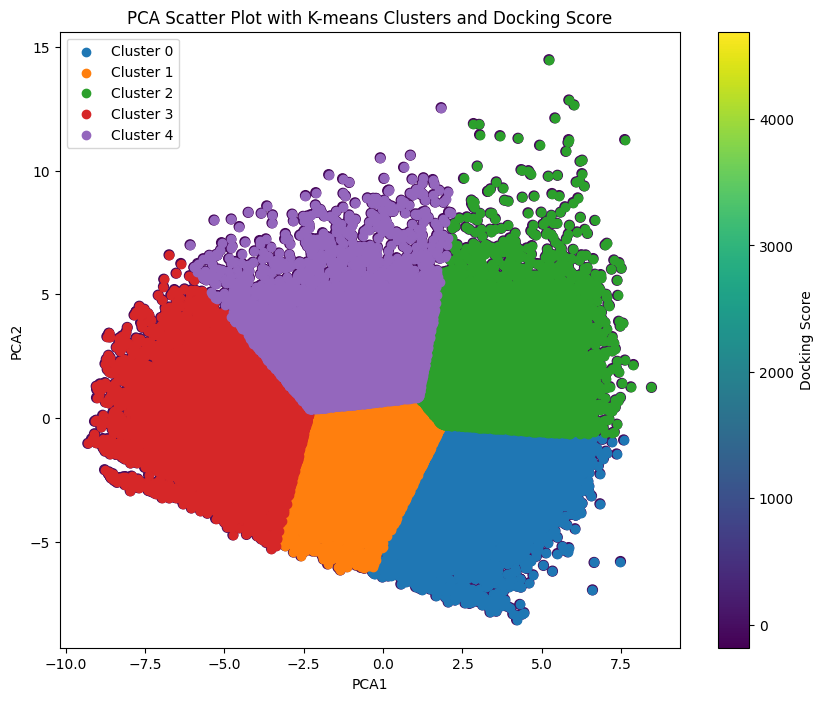

In [ ]:
# Feature Scaling
X = df.drop('score', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
# Create PCA DataFrame *with the SAME INDEX as df*
pca_result_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'], index=df.index)  # Crucial: Keep the original index

# Safely add PCA results back to the original DataFrame

df = pd.concat([df, pca_result_df], axis=1)  # Use concat with axis=1 for column-wise addition


# K-means Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df[['PCA1', 'PCA2']]) # Use the PCA columns directly

# Visualize Clusters with Docking Score as Color
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['score'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Docking Score')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Scatter Plot with K-means Clusters and Docking Score')

# Overlay Cluster Boundaries
for i in range(n_clusters):
    cluster_points = df[df['Cluster'] == i]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {i}')
plt.legend()
plt.show()




--- 1. Statistical Analysis of Docking Scores per Cluster ---
              mean        std  count
Cluster                             
0       -64.407425  24.234783  15461
1       -66.507050  31.437755  23918
2       -79.762495  46.622963  18946
3       -59.922192  26.317240  19088
4       -87.090768  30.320244  17244

--- ANOVA Test ---
                  sum_sq       df            F  PR(>F)
C(Cluster)  9.411204e+06      4.0  2162.737003     0.0
Residual    1.029701e+08  94652.0          NaN     NaN

--- Tukey's HSD Post-Hoc Test ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1  -2.0996   0.0  -3.0281  -1.1712   True
     0      2 -15.3551   0.0 -16.3302   -14.38   True
     0      3   4.4852   0.0   3.5118   5.4587   True
     0      4 -22.6833   0.0 -23.6798 -21.6868   True
     1      2 -13.2554   0.0 -14.1305 -12.3804   True
     1      3   6.5849   0

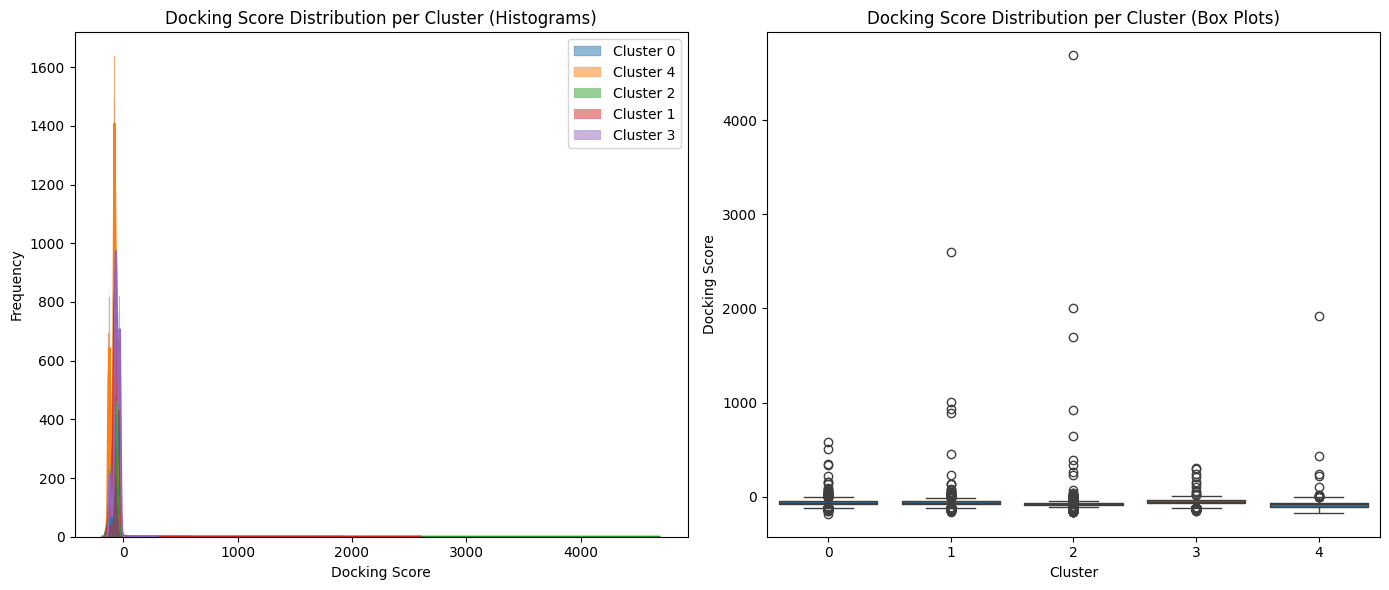

In [ ]:
#  Statistical Analysis of Docking Scores per Cluster
print("\n--- 1. Statistical Analysis of Docking Scores per Cluster ---")
cluster_stats = df.groupby('Cluster')['score'].agg(['mean', 'std', 'count'])
print(cluster_stats)

# Perform ANOVA test
import statsmodels.formula.api as sm
import statsmodels.api as sa
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA test
model = sm.ols('score ~ C(Cluster)', data=df).fit()
anova_table = sa.stats.anova_lm(model, typ=2)
print("\n--- ANOVA Test ---")
print(anova_table)

# Post-hoc test (Tukey's HSD)
m_comp = pairwise_tukeyhsd(df['score'], df['Cluster'], alpha=0.05)
print("\n--- Tukey's HSD Post-Hoc Test ---")
print(m_comp)

# Examine Descriptor Loadings (Contribution to PCA)
print("\n--- 2. Examining PCA Loadings ---")
try:
    pca = PCA(n_components=2)
    X = df.drop(['score', 'Cluster', 'PCA1', 'PCA2'], axis=1)
    pca.fit(X)

    loadings = pca.components_
    loadings_df = pd.DataFrame(loadings.T, index=X.columns, columns=['PCA1', 'PCA2'])
    print("PCA Loadings:")
    print(loadings_df)
except Exception as e:
    print(f"Error: {e}")

# Representative Compound Analysis (Example: top 3 and bottom 3 docking scores per cluster)
print("\n--- 3. Representative Compound Analysis (Top/Bottom Docking Scores per Cluster) ---")

def get_representative_compounds(df, n=3):
    representative_compounds = {}
    for cluster in df['Cluster'].unique():
        cluster_df = df[df['Cluster'] == cluster].sort_values('score', ascending=False)
        top_n = cluster_df.head(n)
        bottom_n = cluster_df.tail(n)
        representative_compounds[f'Cluster {cluster} Top {n}'] = top_n
        representative_compounds[f'Cluster {cluster} Bottom {n}'] = bottom_n
    return representative_compounds

representative_compounds = get_representative_compounds(df)
for key, comp_df in representative_compounds.items():
    print(f"\n--- {key} ---")
    print(comp_df[['score']])  # Print docking scores.  Add other columns if needed.


# Visualize Docking Score Distributions per Cluster (Histograms and Box Plots)
print("\n--- 4. Visualizing Docking Score Distributions per Cluster ---")
plt.figure(figsize=(14, 6))

# Histograms
plt.subplot(1, 2, 1)
for cluster in df['Cluster'].unique():
    sns.histplot(df[df['Cluster'] == cluster]['score'], label=f'Cluster {cluster}', kde=True)
plt.xlabel('Docking Score')
plt.ylabel('Frequency')
plt.title('Docking Score Distribution per Cluster (Histograms)')
plt.legend()

# Box Plots
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='score', data=df)
plt.xlabel('Cluster')
plt.ylabel('Docking Score')
plt.title('Docking Score Distribution per Cluster (Box Plots)')

plt.tight_layout()
plt.show()


The visualization confirms the initial assessment of the PCA scatter plot. Cluster 2, which appeared to have more yellow/green points (higher docking scores), indeed has a distribution shifted towards higher values. Clusters 0, 1, 3, and 4, which appeared to have more blue/purple points (lower docking scores), have distributions concentrated near zero.

In [ ]:
# Summary Statistics for Each Cluster
cluster_summary = df.groupby('Cluster')['score'].agg(['mean', 'median', 'std', 'count', 'min', 'max'])
print(cluster_summary)


              mean     median        std  count       min        max
Cluster                                                             
0       -64.407425 -64.225590  24.234783  15461 -182.9720   585.2581
1       -66.507050 -67.273950  31.437755  23918 -162.5844  2603.5590
2       -79.762495 -79.095180  46.622963  18946 -166.7088  4691.1410
3       -59.922192 -59.893875  26.317240  19088 -149.7352   302.5186
4       -87.090768 -79.730845  30.320244  17244 -172.2308  1923.1780


In [ ]:
# Separate features (X) and target (y)
X = df.drop(['score', 'Cluster', 'PCA1', 'PCA2'], axis=1)  # Drop score, cluster, and PCA columns
y = df['score']  # Target variable is the docking score

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training data, then transform
X_test = scaler.transform(X_test)  # Transform test data using the fitted scaler

# 2. Model Training and Evaluation
# Define a dictionary of regression models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Neural Network": MLPRegressor(random_state=42, max_iter=2000, solver='adam', learning_rate_init=0.001)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  # Train the model

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'R2': r2}  # Store the results
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# 3. Results and Comparison
print("\n--- Model Comparison ---")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}")

# 4. Feature Importance (Example: Random Forest)
print("\n--- Feature Importance (Random Forest) ---")
try:
    rf_model = models["Random Forest"]  # Access the trained Random Forest model
    importances = rf_model.feature_importances_
    feature_names = X.columns  # Get feature names from the DataFrame

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for f in range(X.shape[1]):
        print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

except KeyError:
    print("Random Forest model not found. Skipping feature importance.")


Training Linear Regression...
Linear Regression - MSE: 1989.17, R2: 0.10
Training Random Forest...
Random Forest - MSE: 1816.71, R2: 0.18
Training Gradient Boosting...
Gradient Boosting - MSE: 1864.54, R2: 0.16
Training Neural Network...
Neural Network - MSE: 1860.00, R2: 0.16

--- Model Comparison ---
Linear Regression: MSE = 1989.17, R2 = 0.10
Random Forest: MSE = 1816.71, R2 = 0.18
Gradient Boosting: MSE = 1864.54, R2 = 0.16
Neural Network: MSE = 1860.00, R2 = 0.16

--- Feature Importance (Random Forest) ---
Feature ranking:
1. feature TPSA_NO (0.23068099081096607)
2. feature MolLogP (0.12462705779869608)
3. feature FSP3 (0.08553151688658359)
4. feature RotBondCount (0.0814638095545693)
5. feature XLogP (0.06831119947810278)
6. feature TPSA_NOPS (0.06733377355569278)
7. feature NumHAcceptors (0.051099016195606445)
8. feature NumHDonors (0.04254813829547596)
9. feature AtomCount (0.031972748963909156)
10. feature MW_EXACT (0.028243442110853407)
11. feature HBA (0.025300098942593777)


Regression algorithms used to predict docking scores from chemical features. The MSE and R2 values quantify the accuracy of those predictions, and the feature importance ranking highlights which chemical features were most influential in making those predictions.